In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

import os

from model.datasets import get_loaders
from model.ddpm import DiffusionTrainer, DiffusionSampler
from model.unet import Unet
from model.training import train, sample
from model.utils import SaveBestModel, load_model, plot_images
from model.metrics import fid_score

import gc
from tqdm.notebook import tqdm

In [34]:
torch.cuda.empty_cache()
gc.collect()

7087

In [3]:
CUDA = 0
batch_size = 64

train_loader, val_loader = get_loaders('cifar10', batch_size=batch_size)
device = torch.device(f"cuda:{CUDA}" if torch.cuda.is_available() else "cpu")
device

Files already downloaded and verified


In [4]:
config = {
    'lr': 2e-4,
    'start_epoch': 0,
    'n_epochs': 5,
    'warmup': 5000,
    'model_path': 'bin/cifar10.pth'
}

unet = Unet(T=1000, ch=128, ch_mult=[1, 2, 2, 2], attn=[1], num_res_blocks=2, dropout=0.1)
trainer = DiffusionTrainer(unet).to(device)

optimizer = optim.Adam(trainer.parameters(), lr=config['lr'])
#optimizer = optim.SGD(model.parameters(), lr=args.lr)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lambda epoch: min(epoch, config['warmup']) / config['warmup'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

model_saver = SaveBestModel()

writer = SummaryWriter()

In [5]:
train(
    trainer,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    device,
    config['start_epoch'] + config['n_epochs'],
    config['start_epoch'],
    model_saver,
    config['model_path'],
    writer
)

Validating epoch 1/5: 100%|██████████| 79/79 [00:11<00:00,  6.72it/s]


train loss: 0.08122
val loss: 0.04115
New best model with loss 0.04115 is saved


Validating epoch 2/5: 100%|██████████| 79/79 [00:11<00:00,  6.69it/s]


train loss: 0.03826
val loss: 0.03500
New best model with loss 0.03500 is saved


Training epoch 3/5:   4%|▎         | 26/704 [00:12<05:26,  2.07it/s]


KeyboardInterrupt: 

In [10]:
trainer.load_state_dict(torch.load(config['model_path'])['model_state_dict'])
sampler = DiffusionSampler(trainer.model).to(device)
sampler.eval()



DiffusionSampler(
  (model): Unet(
    (time_embedding): TimeEmbedding(
      (timembedding): Sequential(
        (0): Embedding(1000, 128)
        (1): Linear(in_features=128, out_features=512, bias=True)
        (2): Swish()
        (3): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (head): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downblocks): ModuleList(
      (0): ResBlock(
        (block1): Sequential(
          (0): GroupNorm(32, 128, eps=1e-05, affine=True)
          (1): Swish()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (temb_proj): Sequential(
          (0): Swish()
          (1): Linear(in_features=512, out_features=128, bias=True)
        )
        (block2): Sequential(
          (0): GroupNorm(32, 128, eps=1e-05, affine=True)
          (1): Swish()
          (2): Dropout(p=0.1, inplace=False)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), pad

In [12]:
with torch.no_grad():
    x_T = torch.randn((batch_size, 3, 32, 32))
    batch_images = sampler(x_T).cpu()

#fake_data = sample(model, batch_size, (3, 32, 32), batch_size, device)
#torch.save(fake_data, 'fake_data.pt')

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_gather)

In [79]:
real_data = next(iter(dataloader))[0]
real_data = denormalize(real_data).detach().cpu()

fake_data = torch.load('fake_data.pt')
fake_data = denormalize(fake_data).detach().cpu()

print(real_data.shape, real_data.dtype)
print(fake_data.shape, fake_data.dtype)

torch.Size([64, 3, 32, 32]) torch.float32
torch.Size([64, 3, 32, 32]) torch.float32


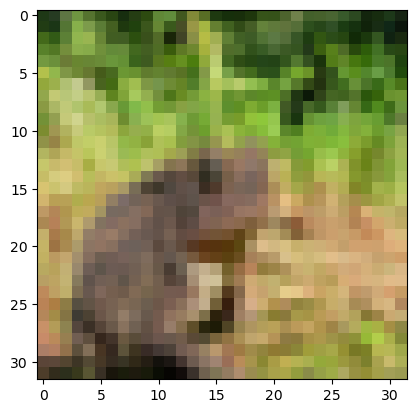

In [78]:
import matplotlib.pyplot as plt

plt.imshow(real_data[0,...].permute(1, 2, 0).cpu())

In [81]:
fid = fid_score(real_data, fake_data)
fid

7.923732280731201